In [2]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import sys
import numpy as np
import pickle

sys.path.append('D:\\Program\\MyCode\\Round_robin_SL\\Round-Robin')
from models import *
from clients_datasets import *
from tqdm.notebook import tqdm
from utils import *
from AttFunc import *
from Fisher_LeNet import *

In [2]:
batch_size = 600
epochs = 30
NC = 10
dataset = 'svhn'

clients_trainloader = load_clients_trainsets(dataset, NC, batch_size)
clients_testloader = load_clients_testsets(dataset, NC, batch_size)

server, server_opt, clients, clients_opts = set_model_and_opt(dataset, NC)
client_level = 1
server_level = 6

criterion = torch.nn.CrossEntropyLoss()

Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat


In [3]:
am = ResNet_9().cuda()

att_type = 'unit'
acc0 = 95.48
betas = []

for i in range(10):
    beta = simulated_annealing(dataset, 1, 500, att_type, acc0,  clients_testloader[8])
    betas.append(beta)
    print(beta)

beta_mean, beta_range = data_process(betas)
print('------------------------------------')
print(beta_mean)

1.7984340630558375
1.810358605994696
0.24921175591575484
2.0
0.7158779340290633
0.8515051817473478
0.8584296785302926
2.0
1.5004971458689895
1.114763631439426
------------------------------------
1.3076303886542078


In [4]:
mal_client_id = [3,6]

In [5]:
acc0 = 95.48
att_type = 'unit'
acc1_varying = []
drop_varying = []
clients_acc1 = []
clients_drop = []
iters = 10
mode = 'Basic'


for iter in tqdm(range(iters), desc="Training", unit="iter"):
    batch_size = 600
    epochs = 30
    NC = 10
    dataset = 'svhn'

    clients_trainloader = load_clients_trainsets(dataset, NC, batch_size)
    clients_testloader = load_clients_testsets(dataset, NC, batch_size)

    server, server_opt, clients, clients_opts = set_model_and_opt(dataset, NC)
    client_level = 1
    server_level = 6

    criterion = torch.nn.CrossEntropyLoss()
    # train
    server.train()
    for i in range(NC):
        clients[i].train()
    server.apply(init_weights)
    clients[0].apply(init_weights)
    last_trained_params = clients[0].state_dict()
    for epoch in range(epochs):
        beta = beta_mean
        for idx, client in enumerate(clients):
            client.load_state_dict(last_trained_params)
            for j, data in enumerate(clients_trainloader[idx]):
                # training part
                images, labels = data
                images = images.cuda()
                labels = labels.cuda()
                smashed_data = client.forward(images, client_level=client_level)
                output = server.forward(smashed_data, server_level=server_level)
                clients_opts[idx].zero_grad()
                server_opt.zero_grad()
                loss = criterion(output, labels)
                loss.backward()
                clients_opts[idx].step()
                server_opt.step()
            # weight sharing
            last_trained_params = client.state_dict()
            # attack part
            if idx in mal_client_id:
                benign_params = list(client.parameters())[:2]
                mal_params = perturbation(beta=beta, bp=benign_params, type=att_type)
                last_trained_params['conv1.0.weight'] = mal_params[0]
                last_trained_params['conv1.0.bias'] = mal_params[1]
    for i in range(NC):
        clients[i].load_state_dict(last_trained_params)

    # test
    server.eval()
    for i in range(NC):
        clients[i].eval()
    with torch.no_grad():
        for idx, client in enumerate(clients):
            correct = 0
            total = 0
            acc1 = 0
            for data in clients_testloader[idx]:
                images, labels = data
                images, labels = images.cuda(), labels.cuda()

                smashed_data = client.forward(images, client_level=client_level)
                output = server.forward(smashed_data, server_level=server_level)
                _, pre = torch.max(output.data, 1)
                total += images.shape[0]
                correct += (pre == labels).sum().item()
            acc1 = 100 * correct / total
            clients_acc1.append(acc1)
            drop = acc0 - acc1
            clients_drop.append(drop)
    acc1 = np.mean(clients_acc1)
    acc1_varying.append(acc1)
    drop = np.mean(clients_drop)
    drop_varying.append(drop)

Training:   0%|          | 0/10 [00:00<?, ?iter/s]

Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat
Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat
Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat
Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat
Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat
Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat
Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat
Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat
Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: dat

In [6]:
print(acc1_varying)
print(drop_varying)
print('-----------------------------')
acc1_mean, acc1_range = data_process(acc1_varying)
print('acc1:')
print(acc1_mean)
print(acc1_range)
print('-----------------------------')
drop_mean, drop_range = data_process(drop_varying)
print('drop:')
print(drop_mean)
print(drop_range)

[93.25827076521065, 90.92458748708361, 92.62186547130722, 92.75119788227337, 92.88565509606367, 93.31205412282767, 93.69235890358276, 93.96126109658417, 94.17296675485119, 94.36038619034046]
[2.221729234789355, 4.555412512916389, 2.8581345286928213, 2.7288021177266257, 2.5943449039363227, 2.167945877172333, 1.7876410964172553, 1.5187389034158312, 1.3070332451488231, 1.1196138096595427]
-----------------------------
acc1:
93.05179446659383
0.5608562405543012
-----------------------------
drop:
2.428205533406159
0.5608562405542927


In [7]:
acc0 = 95.48
att_type = 'unit'
acc1_varying = []
drop_varying = []
clients_acc1 = []
clients_drop = []
iters = 10
mode = 'Fisher'


for iter in tqdm(range(iters), desc="Training", unit="iter"):
    batch_size = 600
    epochs = 30
    NC = 10
    dataset = 'svhn'

    clients_trainloader = load_clients_trainsets(dataset, NC, batch_size)
    clients_testloader = load_clients_testsets(dataset, NC, batch_size)

    server, server_opt, clients, clients_opts = set_model_and_opt(dataset, NC)
    client_level = 1
    server_level = 6

    criterion = torch.nn.CrossEntropyLoss()
    # train
    server.train()
    for i in range(NC):
        clients[i].train()
    server.apply(init_weights)
    clients[0].apply(init_weights)
    last_trained_params = clients[0].state_dict()
    for epoch in range(epochs):
        beta = beta_mean
        for idx, client in enumerate(clients):
            client.load_state_dict(last_trained_params)
            for j, data in enumerate(clients_trainloader[idx]):
                # training part
                images, labels = data
                images = images.cuda()
                labels = labels.cuda()
                smashed_data = client.forward(images, client_level=client_level)
                output = server.forward(smashed_data, server_level=server_level)
                clients_opts[idx].zero_grad()
                server_opt.zero_grad()
                loss = criterion(output, labels)
                loss.backward()
                clients_opts[idx].step()
                server_opt.step()
            # weight sharing
            last_trained_params = client.state_dict()
            # attack part
            if idx in mal_client_id :
                benign_params = list(client.parameters())[:2]

                fisher_matrix = {}
                for param_name, param in client.named_parameters():
                    if param_name == 'conv1.0.weight':
                        grad = param.grad.cpu().detach().numpy()
                        if param_name not in fisher_matrix:
                            fisher_matrix[param_name] = grad ** 2
                        else:
                            fisher_matrix[param_name] += grad ** 2
                    if param_name == 'conv1.0.bias':
                        grad = param.grad.cpu().detach().numpy()
                        if param_name not in fisher_matrix:
                            fisher_matrix[param_name] = grad ** 2
                        else:
                            fisher_matrix[param_name] += grad ** 2
                weight_positions = []
                bias_positions = []
                weight_positions.append(find_positions(fisher_matrix['conv1.0.weight'], 0.15))
                bias_positions.append(find_positions(fisher_matrix['conv1.0.bias'], 0.15))

                mal_params = fisher_perturbation(client_level, beta, benign_params, weight_positions, bias_positions, type=att_type)
                last_trained_params['conv1.0.weight'] = mal_params[0]
                last_trained_params['conv1.0.bias'] = mal_params[1]
    for i in range(NC):
        clients[i].load_state_dict(last_trained_params)

    # test
    server.eval()
    for i in range(NC):
        clients[i].eval()
    with torch.no_grad():
        for idx, client in enumerate(clients):
            correct = 0
            total = 0
            acc1 = 0
            for data in clients_testloader[idx]:
                images, labels = data
                images, labels = images.cuda(), labels.cuda()

                smashed_data = client.forward(images, client_level=client_level)
                output = server.forward(smashed_data, server_level=server_level)
                _, pre = torch.max(output.data, 1)
                total += images.shape[0]
                correct += (pre == labels).sum().item()
            acc1 = 100 * correct / total
            clients_acc1.append(acc1)
            drop = acc0 - acc1
            clients_drop.append(drop)
    acc1 = np.mean(clients_acc1)
    acc1_varying.append(acc1)
    drop = np.mean(clients_drop)
    drop_varying.append(drop)

Training:   0%|          | 0/10 [00:00<?, ?iter/s]

Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat
Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat
Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat
Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat
Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat
Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat
Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat
Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat
Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: dat

In [8]:
print(acc1_varying)
print(drop_varying)
print('-----------------------------')
acc1_mean, acc1_range = data_process(acc1_varying)
print('acc1:')
print(acc1_mean)
print(acc1_range)
print('-----------------------------')
drop_mean, drop_range = data_process(drop_varying)
print('drop:')
print(drop_mean)
print(drop_range)

[95.50936736708738, 95.32882565490722, 94.86401576108864, 94.93220188450877, 95.10218594520207, 94.8211231811575, 94.81901716853943, 94.93508170001174, 94.98950132834115, 94.56054059684176]
[-0.02936736708736447, 0.15117434509278027, 0.6159842389113858, 0.5477981154912275, 0.37781405479793506, 0.6588768188424946, 0.6609828314605714, 0.54491829998826, 0.4904986716588749, 0.9194594031582407]
-----------------------------
acc1:
94.96459732383047
0.23817018411342872
-----------------------------
drop:
0.5154026761695366
0.2381701841134507


In [9]:
acc0 = 95.48
att_type = 'unit'
acc1_varying = []
drop_varying = []
clients_acc1 = []
clients_drop = []
iters = 10
mode = 'Taylor'


for iter in tqdm(range(iters), desc="Training", unit="iter"):
    batch_size = 600
    epochs = 30
    NC = 10
    dataset = 'svhn'

    clients_trainloader = load_clients_trainsets(dataset, NC, batch_size)
    clients_testloader = load_clients_testsets(dataset, NC, batch_size)

    server, server_opt, clients, clients_opts = set_model_and_opt(dataset, NC)
    client_level = 1
    server_level = 6

    criterion = torch.nn.CrossEntropyLoss()
    # train
    server.train()
    for i in range(NC):
        clients[i].train()
    server.apply(init_weights)
    clients[0].apply(init_weights)
    last_trained_params = clients[0].state_dict()
    for epoch in range(epochs):
        beta = beta_mean
        for idx, client in enumerate(clients):
            client.load_state_dict(last_trained_params)
            for j, data in enumerate(clients_trainloader[idx]):
                # training part
                images, labels = data
                images = images.cuda()
                labels = labels.cuda()
                smashed_data = client.forward(images, client_level=client_level)
                output = server.forward(smashed_data, server_level=server_level)
                clients_opts[idx].zero_grad()
                server_opt.zero_grad()
                loss = criterion(output, labels)
                loss.backward()
                clients_opts[idx].step()
                server_opt.step()
            # weight sharing
            last_trained_params = client.state_dict()
            # attack part
            if idx in mal_client_id:
                benign_params = list(client.parameters())[:2]

                Taylor_scores = {}
                for param_name, param in client.named_parameters():
                    if param.grad is not None:
                        Taylor_scores[param_name] = torch.abs(param * param.grad)

                weight_positions = []
                bias_positions = []
                weight_positions.append(find_positions(Taylor_scores['conv1.0.weight'].cpu().detach().numpy(), 0.15))
                bias_positions.append(find_positions(Taylor_scores['conv1.0.bias'].cpu().detach().numpy(), 0.15))

                mal_params = fisher_perturbation(client_level, beta, benign_params, weight_positions, bias_positions, type=att_type)
                last_trained_params['conv1.0.weight'] = mal_params[0]
                last_trained_params['conv1.0.bias'] = mal_params[1]
    for i in range(NC):
        clients[i].load_state_dict(last_trained_params)

    # test
    server.eval()
    for i in range(NC):
        clients[i].eval()
    with torch.no_grad():
        for idx, client in enumerate(clients):
            correct = 0
            total = 0
            acc1 = 0
            for data in clients_testloader[idx]:
                images, labels = data
                images, labels = images.cuda(), labels.cuda()

                smashed_data = client.forward(images, client_level=client_level)
                output = server.forward(smashed_data, server_level=server_level)
                _, pre = torch.max(output.data, 1)
                total += images.shape[0]
                correct += (pre == labels).sum().item()
            acc1 = 100 * correct / total
            clients_acc1.append(acc1)
            drop = acc0 - acc1
            clients_drop.append(drop)
    acc1 = np.mean(clients_acc1)
    acc1_varying.append(acc1)
    drop = np.mean(clients_drop)
    drop_varying.append(drop)

Training:   0%|          | 0/10 [00:00<?, ?iter/s]

Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat
Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat
Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat
Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat
Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat
Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat
Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat
Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat
Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: dat

In [10]:
print(acc1_varying)
print(drop_varying)
print('-----------------------------')
acc1_mean, acc1_range = data_process(acc1_varying)
print('acc1:')
print(acc1_mean)
print(acc1_range)
print('-----------------------------')
drop_mean, drop_range = data_process(drop_varying)
print('drop:')
print(drop_mean)
print(drop_range)

[95.71296973302104, 95.17133869521933, 94.44019111037936, 94.51253258233882, 94.54057353178095, 94.75710064345387, 94.85084688579062, 94.78094296844066, 94.6198691074021, 94.34926541099628]
[-0.2329697330210351, 0.30866130478067577, 1.0398088896206497, 0.9674674176611809, 0.939426468219057, 0.7228993565461456, 0.62915311420939, 0.6990570315593594, 0.8601308925979013, 1.1307345890037122]
-----------------------------
acc1:
94.7521899012718
0.23097777838852096
-----------------------------
drop:
0.727810098728199
0.2309777783885113


In [ ]:
# 记录原始信息
val = {
    'Baseline': [95.48],
    'Basic': [93.47, 93.05, 71.26],
    'Fisher': [58.23, 94.96, 91.18],
    'Taylor': [92.49, 94.75, 75.16]
}

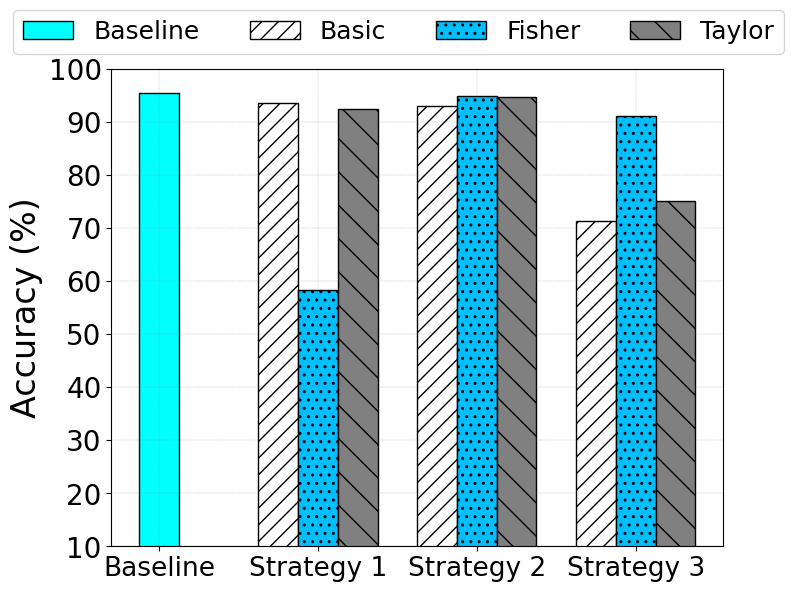

In [3]:
x = ['Baseline', 'Strategy 1', 'Strategy 2', 'Strategy 3']
val = {
    'Baseline': [95.48],
    'Basic': [93.47, 93.05, 71.26],
    'Fisher': [58.23, 94.96, 91.18],
    'Taylor': [92.49, 94.75, 75.16]
}

# 设置柱状图的宽度和 x 轴位置
bar_width = 0.25
x_positions = np.arange(len(x))

# 创建图表
fig, ax = plt.subplots(figsize=(8, 6))

# Baseline的单个柱状图
ax.bar(x_positions[0], val['Baseline'][0], width=bar_width, label='Baseline', color='cyan', edgecolor='black')

# 攻击策略的柱状图颜色和样式设置
strategies = ['Basic', 'Fisher', 'Taylor']
colors = ['white', 'deepskyblue', 'gray']
# colors = ['red', 'green', 'blue']
hatches = ['//', '..', '\\']

# 绘制每个攻击策略的柱状图
for i, strategy in enumerate(strategies):
    for j in range(3):  # 每个策略有三个值
        ax.bar(
            x_positions[j + 1] + (i - 1) * bar_width,
            val[strategy][j],
            width=bar_width,
            color=colors[i],
            edgecolor='black',
            hatch=hatches[i],
            label=strategy if j == 0 else ""  # 避免重复显示图例
        )

# 设置图例和轴标签
plt.xticks(fontsize=19)
plt.yticks(fontsize=20)
plt.ylim(10, 100)
ax.legend(fontsize=18, loc='upper center', bbox_to_anchor=(0.47, 1.15), ncol=4)
ax.set_ylabel('Accuracy (%)', fontsize=24)
ax.set_xticks(x_positions)
ax.set_xticklabels(x)
# 显示图表
plt.grid(True, linestyle=':', linewidth=0.3, color='gray')
plt.tight_layout()
plt.show()